# NYC Property Prices

## Initial Exploration

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)

In [2]:
# !ls gdrive/Othercomputers/'My Mac'/'Fall 2023'/BA810/Project/nyc-rolling-sales.csv

In [3]:
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import randint

# Import necessary libraries
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_halving_search_cv # needed to enable Halving features
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [4]:
import pandas as pd
nyc = pd.read_csv('https://raw.githubusercontent.com/eshentong/BA810-team-project/main/nyc-rolling-sales.csv')

In [5]:
print(nyc.shape)
nyc

(84548, 22)


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,8409,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,...,2,0,2,2400,2575,1998,1,B9,450000,2016-11-28 00:00:00
84544,8410,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,...,2,0,2,2498,2377,1998,1,B9,550000,2017-04-21 00:00:00
84545,8411,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,...,2,0,2,4000,1496,1925,1,B2,460000,2017-07-05 00:00:00
84546,8412,5,WOODROW,22 STORE BUILDINGS,4,7100,28,,K6,2730 ARTHUR KILL ROAD,...,0,7,7,208033,64117,2001,4,K6,11693337,2016-12-21 00:00:00


### What's up with the first column?

The first column is unnamed.

These values appear to have been used to iterate through each borough's properties. We will simply drop this column.

In [6]:
nyc.drop(columns={nyc.columns[0]}, inplace=True)

### EASE-MENT column

In [7]:
nyc['EASE-MENT'].unique()

array([' '], dtype=object)

EASE-MENT is an empty column so we will remove it as well.

In [8]:
nyc.drop(columns={'EASE-MENT'}, inplace=True)

### Column Wise Exploration

From [Kaggle](https://www.kaggle.com/datasets/new-york-city/nyc-property-sales/data):

This dataset contains the location, address, type, sale price, and sale date of building units sold. A reference on the trickier fields:

**BOROUGH**: A digit code for the borough the property is located in; in order these are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).

**BLOCK; LOT**: The combination of borough, block, and lot forms a unique key for property in New York City. Commonly called a **BBL**.

**BUILDING CLASS AT PRESENT** and **BUILDING CLASS AT TIME OF SALE**: The type of building at various points in time. See the glossary linked to below.

For further reference on individual fields see the [Glossary of Terms](https://www.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf). For the building classification codes see the [Building Classifications Glossary](https://www.nyc.gov/assets/finance/jump/hlpbldgcode.html).

Note that because this is a financial transaction dataset, there are some points that need to be kept in mind:

Many sales occur with a nonsensically small dollar amount: $0 most commonly. These sales are actually transfers of deeds between parties: for example, parents transferring ownership to their home to a child after moving out for retirement.

This dataset uses the financial definition of a building/building unit, for tax purposes. In case a single entity owns the building in question, a sale covers the value of the entire building. In case a building is owned piecemeal by its residents (a condominium), a sale refers to a single apartment (or group of apartments) owned by some individual.

In [9]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   BUILDING CLASS AT PRESENT       84548 non-null  object
 7   ADDRESS                         84548 non-null  object
 8   APARTMENT NUMBER                84548 non-null  object
 9   ZIP CODE                        84548 non-null  int64 
 10  RESIDENTIAL UNITS               84548 non-null  int64 
 11  COMMERCIAL UNITS                84548 non-null  int64 
 12  TOTAL UNITS                     84548 non-null

#### Setting the right dtypes

In [10]:
# Converting to categorical columns

col_to_cat = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT', 'ZIP CODE', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE']
for col in col_to_cat:
   nyc[col] = nyc[col].astype('category')

In [11]:
# Converting to numerical columns

col_to_numeric = ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE', 'YEAR BUILT']
for col in col_to_numeric:
  nyc[col] = pd.to_numeric(nyc[col], errors='coerce')

In [12]:
nyc['LAND SQUARE FEET'].value_counts()

0.0        10326
2000.0      3919
2500.0      3470
4000.0      3044
1800.0      1192
           ...  
5886.0         1
76712.0        1
6777.0         1
10833.0        1
10796.0        1
Name: LAND SQUARE FEET, Length: 6061, dtype: int64

In [13]:
# Converting to datetime column
nyc['SALE DATE'] = pd.to_datetime(nyc['SALE DATE'])

In [14]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         84548 non-null  category      
 1   NEIGHBORHOOD                    84548 non-null  category      
 2   BUILDING CLASS CATEGORY         84548 non-null  category      
 3   TAX CLASS AT PRESENT            84548 non-null  category      
 4   BLOCK                           84548 non-null  category      
 5   LOT                             84548 non-null  category      
 6   BUILDING CLASS AT PRESENT       84548 non-null  category      
 7   ADDRESS                         84548 non-null  object        
 8   APARTMENT NUMBER                84548 non-null  object        
 9   ZIP CODE                        84548 non-null  category      
 10  RESIDENTIAL UNITS               84548 non-null  int64         
 11  CO

## Missing Values Exploration

According to .info(), there are missing values in the following columns: **LAND SQUARE FEET, GROSS SQUARE FEET, SALE PRICE**

We also know from manual observation that there are some missing values in the following columns: **APARTMENT NUMBER**

In [15]:
print('% missing for LAND SQUARE FEET:', round(nyc['LAND SQUARE FEET'].isna().sum()/nyc.shape[0], 2))
print('% missing for GROSS SQUARE FEET:', round(nyc['GROSS SQUARE FEET'].isna().sum()/nyc.shape[0], 2))
print('% missing for SALE PRICE:', round(nyc['SALE PRICE'].isna().sum()/nyc.shape[0], 2))

% missing for LAND SQUARE FEET: 0.31
% missing for GROSS SQUARE FEET: 0.33
% missing for SALE PRICE: 0.17


In [16]:
nyc['SALE PRICE'].value_counts()

0.0          10228
10.0           766
450000.0       427
550000.0       416
650000.0       414
             ...  
191100.0         1
811000.0         1
782990.0         1
2784765.0        1
69300.0          1
Name: SALE PRICE, Length: 10007, dtype: int64

Apart from the missing values in 'SALE PRICE' column, there are also 10994 values in the column which the value equals either 0 (10228) or 10 (766).

In [17]:
nyc['APARTMENT NUMBER'].value_counts()

        65496
4         298
3A        295
2         275
3B        275
        ...  
ST50        1
ST54        1
SU13        1
SU21        1
363         1
Name: APARTMENT NUMBER, Length: 3989, dtype: int64

For Apartment Number, there are 65496 empty columns. We will assume that these are empty since this is the sale of a whole building rather than an apartment.

## Summary Statistics

In [18]:
# suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.2f}'.format

nyc.describe()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,84548.00,84548.00,84548.00,58296.00,56936.00,84548.00,69987.00
mean,2.03,0.19,2.25,3941.68,4045.71,1789.32,1276456.50
std,16.72,8.71,18.97,41983.97,35032.49,537.34,11405255.35
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,1.00,1650.00,1046.75,1920.00,225000.00
50%,1.00,0.00,1.00,2325.00,1680.00,1940.00,530000.00
75%,2.00,0.00,2.00,3500.00,2560.00,1965.00,950000.00
max,1844.00,2261.00,2261.00,4252327.00,3750565.00,2017.00,2210000000.00


In [19]:
nyc.describe(include=['category', 'object'])

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
count,84548,84548,84548,84548,84548,84548,84548,84548,84548,84548,84548,84548
unique,5,254,47,11,11566,2627,167,67563,3989,186,4,166
top,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,5066,1,D4,131-05 40TH ROAD,,10314,1,R4
freq,26736,3068,18235,38633,404,4125,12663,210,65496,1687,41533,12989


In [20]:
nyc.describe(include = 'datetime')

<ipython-input-20-2e89c4609a0d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  nyc.describe(include = 'datetime')


,SALE DATE
count,84548
unique,364
top,2017-06-29 00:00:00
freq,544
first,2016-09-01 00:00:00
last,2017-08-31 00:00:00


## 1. Data Cleaning

In [21]:
nyc_copy=nyc.copy()

### Standardizing column names




- Removing spaces in naming convention

In [22]:
nyc_copy.columns = nyc_copy.columns.str.replace(' ', '_')

In [23]:
# Riya's Part
temp = pd.DataFrame(index=nyc_copy.columns)
temp

""
BOROUGH
NEIGHBORHOOD
BUILDING_CLASS_CATEGORY
TAX_CLASS_AT_PRESENT
BLOCK
LOT
BUILDING_CLASS_AT_PRESENT
ADDRESS
APARTMENT_NUMBER
ZIP_CODE


### Checking for null values

In [24]:
def nyc_df_info():
    temp = pd.DataFrame(index=nyc_copy.columns)
    temp["Datatype"] = nyc_copy.dtypes
    temp["Not null values"] = nyc_copy.count()
    temp["Null values"] = nyc_copy.isnull().sum()
    temp["Percentage of Null values"] = (nyc_copy.isnull().mean())*100
    temp["Unique count"] = nyc_copy.nunique()
    return temp
nyc_df_info()

,Datatype,Not null values,Null values,Percentage of Null values,Unique count
BOROUGH,category,84548,0,0.00,5
NEIGHBORHOOD,category,84548,0,0.00,254
BUILDING_CLASS_CATEGORY,category,84548,0,0.00,47
TAX_CLASS_AT_PRESENT,category,84548,0,0.00,11
BLOCK,category,84548,0,0.00,11566
LOT,category,84548,0,0.00,2627
BUILDING_CLASS_AT_PRESENT,category,84548,0,0.00,167
ADDRESS,object,84548,0,0.00,67563
APARTMENT_NUMBER,object,84548,0,0.00,3989
ZIP_CODE,category,84548,0,0.00,186


In [25]:
nyc_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         84548 non-null  category      
 1   NEIGHBORHOOD                    84548 non-null  category      
 2   BUILDING_CLASS_CATEGORY         84548 non-null  category      
 3   TAX_CLASS_AT_PRESENT            84548 non-null  category      
 4   BLOCK                           84548 non-null  category      
 5   LOT                             84548 non-null  category      
 6   BUILDING_CLASS_AT_PRESENT       84548 non-null  category      
 7   ADDRESS                         84548 non-null  object        
 8   APARTMENT_NUMBER                84548 non-null  object        
 9   ZIP_CODE                        84548 non-null  category      
 10  RESIDENTIAL_UNITS               84548 non-null  int64         
 11  CO

In [26]:
nyc_copy['LAND_SQUARE_FEET'].value_counts()

0.00        10326
2000.00      3919
2500.00      3470
4000.00      3044
1800.00      1192
            ...  
5886.00         1
76712.00        1
6777.00         1
10833.00        1
10796.00        1
Name: LAND_SQUARE_FEET, Length: 6061, dtype: int64

### Dropping Columns

####BOROUGH - NEIGHBORHOOD ASSOCIATION

In [27]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming df is your DataFrame with 'Borough' and 'Neighborhood' columns
contingency_table = pd.crosstab(nyc_copy['BOROUGH'], nyc_copy['NEIGHBORHOOD'])

# Chi-squared test for independence
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

Chi-squared value: 337442.1126549097
P-value: 0.0


In [28]:
import numpy as np

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

cramers_v_value = cramers_v(contingency_table.values)
print(f"Cramér's V value: {cramers_v_value}")

Cramér's V value: 0.9974153128138344


####BOROUGH - ZIP_CODE ASSOCIATION

In [29]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming df is your DataFrame with 'Borough' and 'Neighborhood' columns
contingency_table = pd.crosstab(nyc_copy['BOROUGH'], nyc_copy['ZIP_CODE'])

# Chi-squared test for independence
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

Chi-squared value: 333574.3797433641
P-value: 0.0


In [30]:
import numpy as np

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

cramers_v_value = cramers_v(contingency_table.values)
print(f"Cramér's V value: {cramers_v_value}")

Cramér's V value: 0.9920708589906893


Cramer's V scores show that there are high associations between borough and zip_code, as well as borough and neighborhood.

#### DROPPING CHOSEN COLUMNS

Dropping irrelevant columns:
- `ADDRESS`, `BLOCK`, `LOT`, `APARTMENT_NUMBER``BUILDING_CLASS_AT_TIME_OF_SALE`, `TAX_CLASS_AT_PRESENT`, `BUILDING_CLASS_AT_PRESENT`, `NEIGHBORHOOD`, `ZIP_CODE`, `SALE_DATE`

In [31]:
# #due to one-hard encoding, these cols are too granular
# columns_to_drop = ['ADDRESS', 'BLOCK', 'LOT', 'APARTMENT_NUMBER', 'BUILDING_CLASS_AT_TIME_OF_SALE',
#                    'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT', 'NEIGHBORHOOD', 'ZIP_CODE',
#                    'SALE_DATE']
# nyc_copy.drop(columns=columns_to_drop, inplace=True)
# nyc_copy

In [32]:
#due to one-hard encoding, these cols are too granular
columns_to_drop = ['ADDRESS', 'BLOCK', 'LOT', 'APARTMENT_NUMBER','BUILDING_CLASS_CATEGORY',
                   'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT', 'NEIGHBORHOOD', 'ZIP_CODE',
                   'SALE_DATE']
nyc_copy.drop(columns=columns_to_drop, inplace=True)
nyc_copy

,BOROUGH,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE
0,1,5,0,5,1633.00,6440.00,1900,2,C2,6625000.00
1,1,28,3,31,4616.00,18690.00,1900,2,C7,NaN
2,1,16,1,17,2212.00,7803.00,1900,2,C7,NaN
3,1,10,0,10,2272.00,6794.00,1913,2,C4,3936272.00
4,1,6,0,6,2369.00,4615.00,1900,2,C2,8000000.00
...,...,...,...,...,...,...,...,...,...,...
84543,5,2,0,2,2400.00,2575.00,1998,1,B9,450000.00
84544,5,2,0,2,2498.00,2377.00,1998,1,B9,550000.00
84545,5,2,0,2,4000.00,1496.00,1925,1,B2,460000.00
84546,5,0,7,7,208033.00,64117.00,2001,4,K6,11693337.00


In [33]:
nyc_copy.describe()

,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE
count,84548.00,84548.00,84548.00,58296.00,56936.00,84548.00,69987.00
mean,2.03,0.19,2.25,3941.68,4045.71,1789.32,1276456.50
std,16.72,8.71,18.97,41983.97,35032.49,537.34,11405255.35
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,1.00,1650.00,1046.75,1920.00,225000.00
50%,1.00,0.00,1.00,2325.00,1680.00,1940.00,530000.00
75%,2.00,0.00,2.00,3500.00,2560.00,1965.00,950000.00
max,1844.00,2261.00,2261.00,4252327.00,3750565.00,2017.00,2210000000.00


### Dropping Rows

In [39]:
#dropping empty, 0, very low or outlier sales price rows
nyc_copy = nyc_copy[(nyc_copy['SALE_PRICE'] > 10000) & (nyc_copy['SALE_PRICE'].notna()) & (nyc_copy['SALE_PRICE'] < 5000000)]

#dropping outlier LAND_SQUARE_FEET
nyc_copy['LAND_SQUARE_FEET'] = nyc_copy['LAND_SQUARE_FEET'].fillna(1)  # Use 1 as a placeholder

nyc_copy = nyc_copy[(nyc_copy['LAND_SQUARE_FEET'] > 0) & (nyc_copy['LAND_SQUARE_FEET'] < 50000)]

nyc_copy['LAND_SQUARE_FEET'] = nyc_copy['LAND_SQUARE_FEET'].replace(1, np.nan)

#dropping outlier GROSS_SQUARE_FEET
nyc_copy['GROSS_SQUARE_FEET'] = nyc_copy['GROSS_SQUARE_FEET'].fillna(1)  # Use 1 as a placeholder

nyc_copy = nyc_copy[(nyc_copy['GROSS_SQUARE_FEET'] > 0) & (nyc_copy['GROSS_SQUARE_FEET'] < 50000)]

nyc_copy['GROSS_SQUARE_FEET'] = nyc_copy['GROSS_SQUARE_FEET'].replace(1, np.nan)

#dropping total units
nyc_copy = nyc_copy[(nyc_copy['TOTAL_UNITS'] != 0) & (nyc_copy['TOTAL_UNITS'] != 2261)]

#dropping commercial units
nyc_copy = nyc_copy[nyc_copy['COMMERCIAL_UNITS'] != 2261]

#dropping residential units
nyc_copy = nyc_copy[nyc_copy['RESIDENTIAL_UNITS'] != 1844]

nyc_copy = nyc_copy.drop_duplicates()

<ipython-input-39-dd7e59b070f4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_copy['LAND_SQUARE_FEET'] = nyc_copy['LAND_SQUARE_FEET'].fillna(1)  # Use 1 as a placeholder


In [35]:
nyc_copy

,BOROUGH,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE
3,1,10,0,10,2272.00,6794.00,1913,2,C4,3936272.00
6,1,8,0,8,1750.00,4226.00,1920,2,C4,3192840.00
76,1,1,0,1,NaN,NaN,0,2,R2,620000.00
79,1,1,0,1,NaN,NaN,1920,2,R4,762669.00
80,1,1,0,1,NaN,NaN,1920,2,R4,772851.00
...,...,...,...,...,...,...,...,...,...,...
84541,5,2,0,2,11088.00,2160.00,1994,1,B2,648000.00
84543,5,2,0,2,2400.00,2575.00,1998,1,B9,450000.00
84544,5,2,0,2,2498.00,2377.00,1998,1,B9,550000.00
84545,5,2,0,2,4000.00,1496.00,1925,1,B2,460000.00


## Visualizations for the Report

### Price Distribution

<Figure size 3000x1000 with 0 Axes>

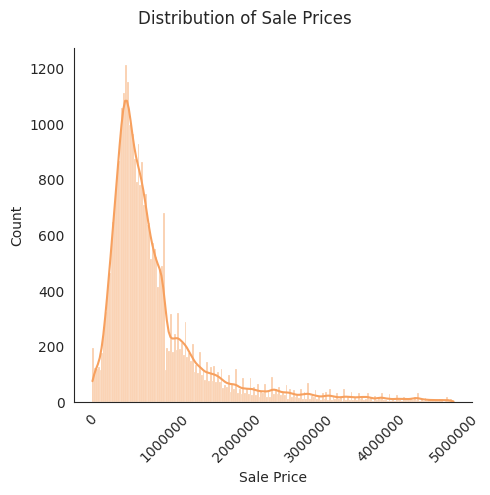

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
sns.set_palette("Oranges_d")
plt.figure(figsize=(30, 10))

dplot = sns.displot(data=nyc_copy, x='SALE_PRICE', bins=200, kde=True, kde_kws={'bw_adjust': 0.5})

dplot.set_axis_labels("Sale Price", "Count")
dplot.fig.suptitle("Distribution of Sale Prices")
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show();

### Gross Square Footage

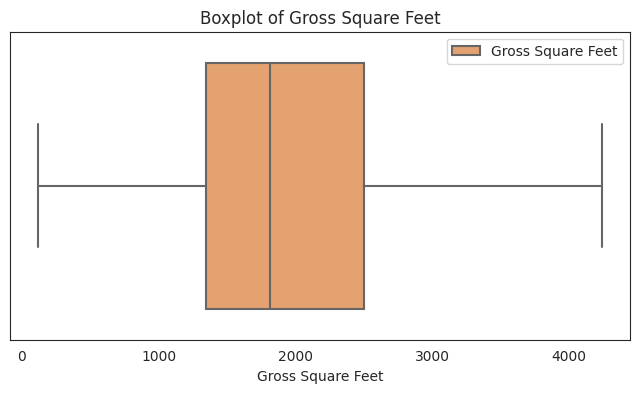

In [51]:
# Boxplot of Gross Square Footage
plt.figure(figsize=(8,4))
sns.boxplot(x='GROSS_SQUARE_FEET', data=nyc_copy ,showfliers=False)
# Adding legend, x-axis title, and y-axis title
plt.legend(labels=['Gross Square Feet'])
plt.xlabel('Gross Square Feet')
# plt.ylabel('Y-axis Title')
plt.title("Boxplot of Gross Square Feet")
plt.show()

Text(0.5, 1.0, 'Price vs Gross Square Feet')

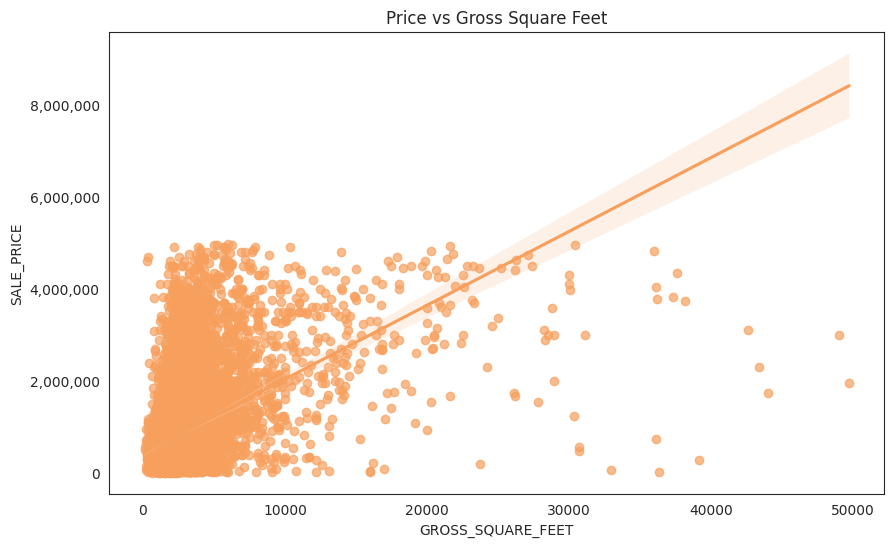

In [52]:
from matplotlib import ticker
# Scatter plot of Gross Square Footage
plt.figure(figsize=(10,6))
ax = sns.regplot(x='GROSS_SQUARE_FEET', y='SALE_PRICE', data=nyc_copy, scatter_kws={'alpha': 0.7})
# Formatting y-axis ticks to display in their original units
formatter = ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}')  # Modify the format if needed
ax.yaxis.set_major_formatter(formatter)
plt.title('Price vs Gross Square Feet')

### Land Square Footage

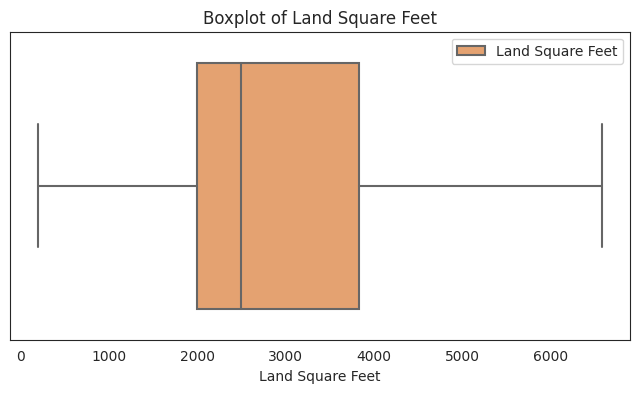

In [61]:
# Boxplot of Land Square Footage
plt.figure(figsize=(8,4))
sns.boxplot(x='LAND_SQUARE_FEET', data=nyc_copy ,showfliers=False)
# Adding legend, x-axis title, and y-axis title
plt.legend(labels=['Land Square Feet'])
plt.xlabel('Land Square Feet')
# plt.ylabel('Y-axis Title')
plt.title("Boxplot of Land Square Feet")
plt.show()

Text(0.5, 1.0, 'Land Square Feet Against Sale Price')

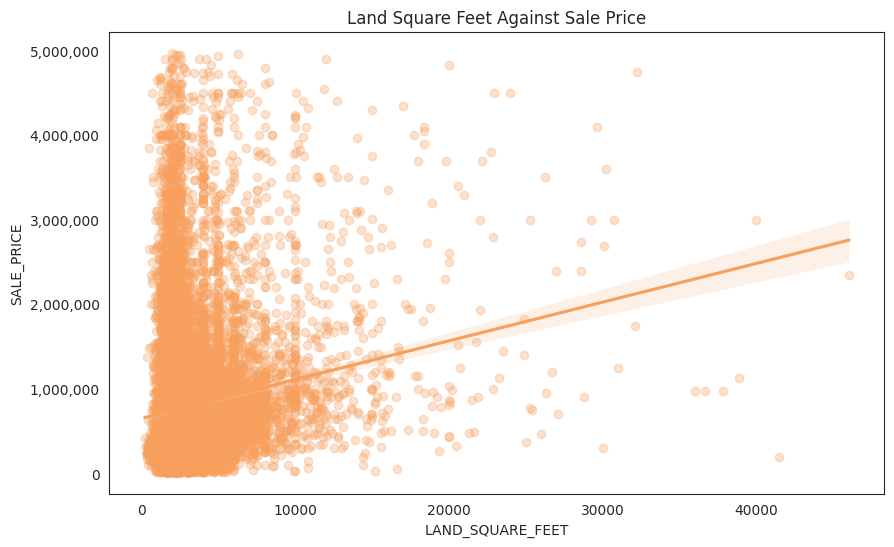

In [63]:
# Scatterplot of Price vs Land Square Footage
plt.figure(figsize=(10,6))
ax = sns.regplot(x='LAND_SQUARE_FEET', y='SALE_PRICE', data=nyc_copy, fit_reg=True, scatter_kws={'alpha':0.3})
# Formatting y-axis ticks to display in their original units
formatter = ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}')  # Modify the format if needed
ax.yaxis.set_major_formatter(formatter)
plt.title('Land Square Feet Against Sale Price')

### Price by Borough

<Figure size 800x600 with 0 Axes>

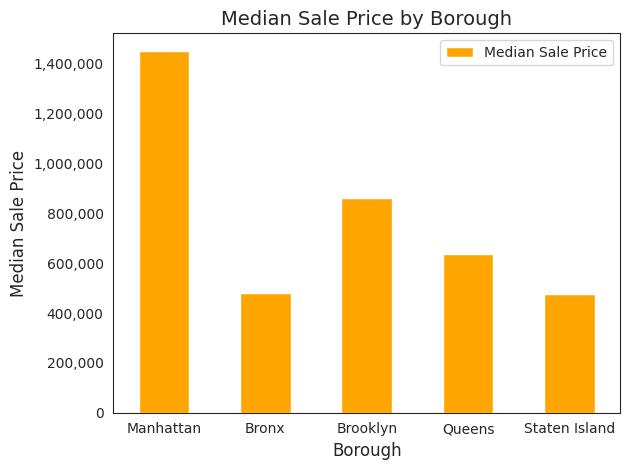

In [54]:
# Assuming 'custom_labels' is a list of custom labels for the boroughs
custom_labels = ['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island']
# Creating the pivot table without specifying custom index labels
pivot = nyc_copy.pivot_table(index='BOROUGH', values='SALE_PRICE', aggfunc=np.median)
# Creating the bar plot
plt.figure(figsize=(8, 6))
ax = pivot.plot(kind='bar', color='orange')
# Adding labels and titles
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Median Sale Price', fontsize=12)  # Y-label remains unchanged
plt.title('Median Sale Price by Borough', fontsize=14)
plt.legend(['Median Sale Price'], fontsize=10)
# Customizing x-axis tick labels with custom entries
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=0)
# Formatting y-axis ticks to display in their original units
formatter = ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}')  # Modify the format if needed
ax.yaxis.set_major_formatter(formatter)
# Displaying the plot
plt.tight_layout()
plt.show()


### Sale Price vs Total Units

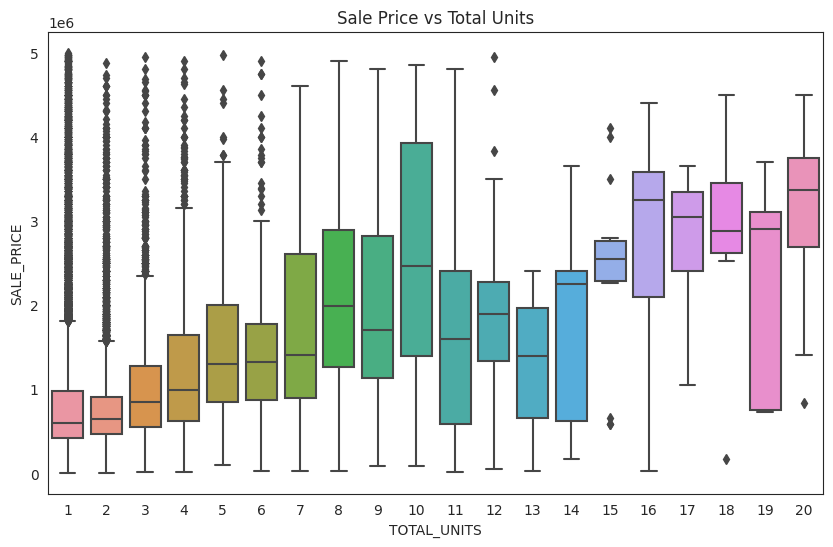

In [60]:
plot = nyc_copy[nyc_copy['TOTAL_UNITS'] <= 20]


plt.figure(figsize=(10,6))
sns.boxplot(x='TOTAL_UNITS', y='SALE_PRICE', data=plot)
plt.title('Sale Price vs Total Units')
plt.show()

## Modeling

### Splitting Dataset

In [ ]:
X = nyc_copy.drop(columns = ['SALE_PRICE'])
y = nyc_copy['SALE_PRICE']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Preprocessing Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

cat_attribs = ['BOROUGH', 'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE']
num_attribs = ['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include='category'))
], verbose_feature_names_out=False)
prep_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7bad07d2e9b0>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7bad07d2c0a0>)],
                  verbose_feature_names_out=False)

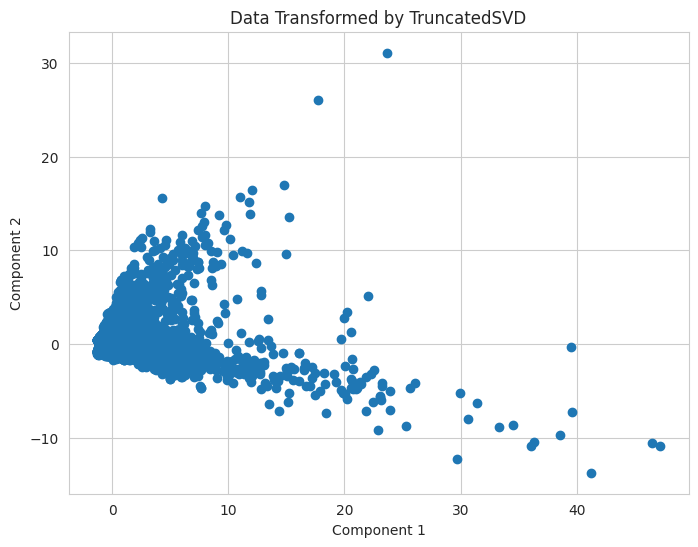

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Assuming 'prep_pipeline' is your preprocessing pipeline
x_train_transformed = prep_pipeline.fit_transform(nyc_copy)
# Initialize TruncatedSVD with the desired number of components
num_components = 10
svd = TruncatedSVD(n_components=num_components)

# Transform your sparse data using TruncatedSVD
x_svd = svd.fit_transform(x_train_transformed)

# Plot the transformed data
plt.figure(figsize=(8, 6))
plt.scatter(x_svd[:, 0], x_svd[:, 1])  # Plotting two of the principal components
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Data Transformed by TruncatedSVD')
plt.show()

### Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

rdg_pipeline = Pipeline([
    ('data_processing', prep_pipeline),
    ('rdg', Ridge()),
])

rdg_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8d8e3589a0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8d8e359b40>)],
                                   verbose_feature_names_out=False)),
                ('rdg', Ridge())])

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV

param_grid = {'rdg__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

grid_search_rdg = GridSearchCV(rdg_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', error_score = 'raise')
grid_search_rdg.fit(X_train, y_train)
print('\n\nThe best parameters are ', grid_search_rdg.best_params_)

grid_cv_res = pd.DataFrame(grid_search_rdg.cv_results_) # convert to DF for convenience
grid_cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)  # sort the data frame
# select only the columns that start with 'param_' and the column 'mean_test_score'
grid_cv_res.filter(regex = '(^param_|mean_test_score)', axis=1).head(10)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ



The best parameters are  {'rdg__alpha': 10}


,param_rdg__alpha,mean_test_score
6,10,-392171964798.88
5,1,-394155775753.12
4,0.10,-398009658489.99
3,0.01,-398964514772.50
2,0.00,-399064171366.23
0,0.00,-399074800689.99
1,0.00,-399083668406.55
7,100,-400353659833.45
8,1000,-434695934352.09
9,10000,-497639319002.08


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

y_pred = grid_search_rdg.predict(X_test)

# Compute R2 Score
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

# Compute RMSE
mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MSE: {mse}')

R2 Score: 0.35484465431457446
MSE: 629019.4603030408


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_pipeline = Pipeline([
    ('data_processing', prep_pipeline),
    ('knn', KNeighborsRegressor()),
])

knn_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8d8e3589a0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8d8e359b40>)],
                                   verbose_feature_names_out=False)),
                ('knn', KNeighborsRegressor())])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distributions
param_dist = {
    'knn__n_neighbors': randint(1, 20),
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': randint(10, 50),
    'knn__p': [1, 2]
}


# Perform Randomized Search Cross Validation
random_search_knn = RandomizedSearchCV(knn_pipeline, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error')
random_search_knn.fit(X_train, y_train)
print('\n\nThe best parameters are ', random_search_knn.best_params_)

random_cv_res = pd.DataFrame(random_search_knn.cv_results_) # convert to DF for convenience
random_cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)  # sort the data frame
# select only the columns that start with 'param_' and the column 'mean_test_score'
random_cv_res.filter(regex = '(^param_|mean_test_score)', axis=1).head(10)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute forc

KeyboardInterrupt: ignored

In [ ]:
y_pred = random_search_knn.predict(X_test)

# Compute R2 Score
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

# Compute RMSE
mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MSE: {mse}')

NotFittedError: ignored

### XGBoost

In [ ]:
import xgboost as xgb
xgb_pipeline = Pipeline([('prep_pipe', prep_pipeline),
                                        ('xgb', xgb.XGBRegressor())])
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep_pipe',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bad07d2e9b0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred= xgb_pipeline.predict(X_test)
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MSE: {mse}')

R2 Score: 0.45322394067380933
MSE: 579077.4814889538


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


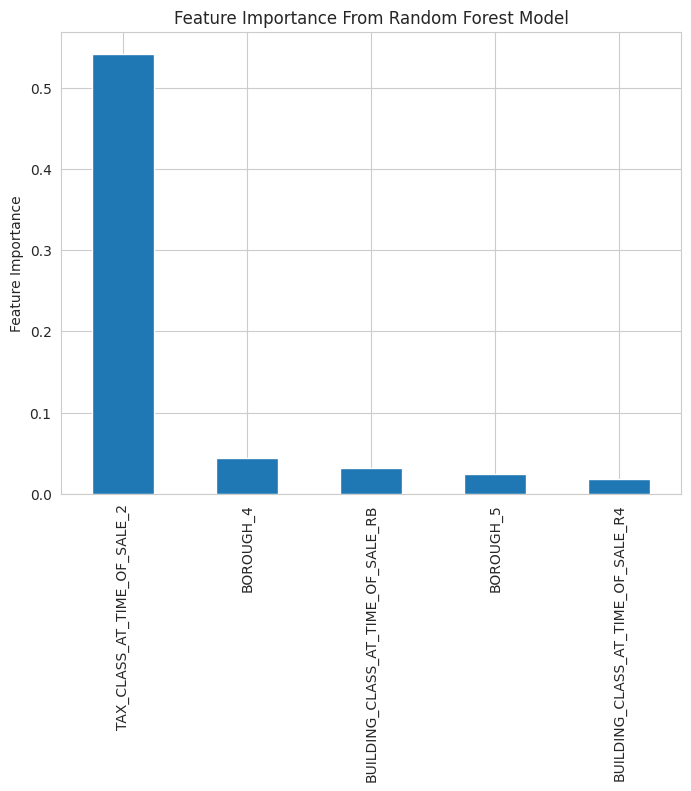

In [ ]:
transformed_feature_names = xgb_pipeline.named_steps['prep_pipe'].get_feature_names_out() # getting the transformed column names

feature_importance = pd.Series(
    xgb_pipeline.named_steps['xgb'].feature_importances_,
    index=transformed_feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feature_importance.head(5).plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Feature Importance From Random Forest Model')
plt.ylabel('Feature Importance');

- RandomSearch for XGBoost

In [ ]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
param_dis= {
    'xgb__eta': uniform(0.01, 0.3),
    'xgb__max_depth': randint(3, 10),
    'xgb__n_estimators': randint(100, 1000)
}

random_search_xgb= RandomizedSearchCV(estimator= xgb_pipeline, param_distributions=param_dis,
                                                                         scoring='neg_mean_squared_error',
                                                                         cv=3, n_jobs= -1, n_iter= 50)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

random_search_xgb.fit(X_train, y_train)

best_params = random_search_xgb.best_params_
best_estimator = random_search_xgb.best_estimator_

best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('\n\nThe best parameters are ', best_params)
print(f'R2 Score: {r2}')
mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MSE: {mse}')

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline= Pipeline([('prep_pipe', prep_pipeline),
                          ('random_forest', RandomForestRegressor(random_state=42))])

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep_pipe',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bad07d2e9b0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bad07d2c0a0>)],
                                   verbose_feature_names_out=False)),
                ('random_forest', RandomForestRegressor(random_state=42))])

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred= rf_pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MSE: {mse}')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2 Score: 0.4686002768320575
MSE: 570877.062274443


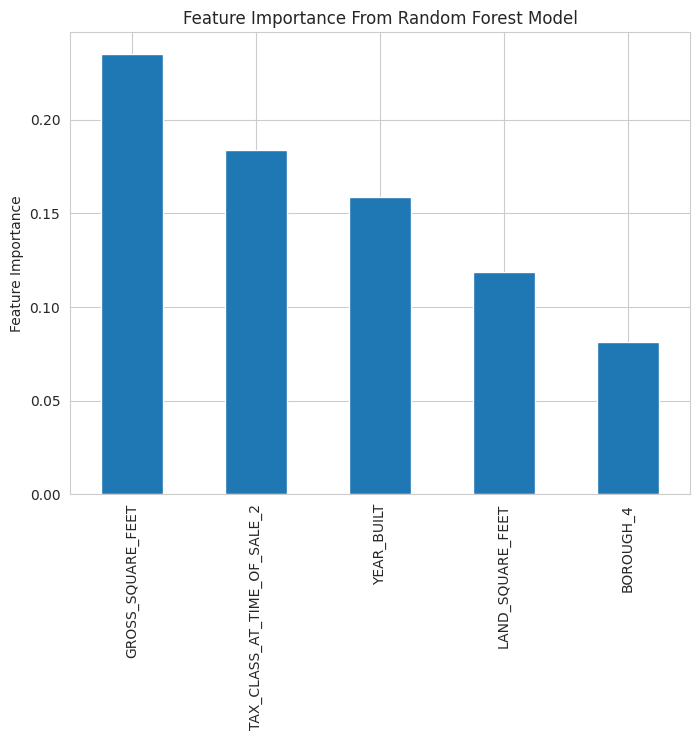

In [ ]:
transformed_feature_names = rf_pipeline.named_steps['prep_pipe'].get_feature_names_out() # getting the transformed column names

feature_importance = pd.Series(
    rf_pipeline.named_steps['random_forest'].feature_importances_,
    index=transformed_feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feature_importance.head(5).plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Feature Importance From Random Forest Model')
plt.ylabel('Feature Importance');

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'random_forest__n_estimators': randint(100,300),
    'random_forest__max_depth': randint (5,20),
    'random_forest__min_samples_split': randint(2, 20),}
random_search = RandomizedSearchCV(estimator=final_pipeline,
                                   param_distributions=param_grid,
                                   scoring='neg_mean_squared_error',
                                   cv=3, n_jobs= -1, n_iter= 15)

In [ ]:
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)
r2 = r2_score(y_test, y_pred)

print('\n\nThe best parameters are ', best_params)

print(f'R2 Score: {r2}')
mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MSE: {mse}')

### Ensemble Method (Stacking)

In [ ]:
# preprocess the training data
tr_X = prep_pipeline.fit_transform(X_train)
tr_y = y_train

# preprocess the test data
t_X = prep_pipeline.transform(X_test)
t_y = y_test

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

estimators = [
     ('rdg', Ridge(alpha = 10)),
     ('knn', KNeighborsRegressor(n_neighbors = 18, weights = 'uniform', leaf_size = 34, algorithm = 'ball_tree', p = 2)),
     ('xgb', xgb.XGBRegressor(eta = 0.062, max_depth = 9, n_estimators = 144)),
     ('random_forest', RandomForestRegressor(n_estimators = 288, max_depth = 18, min_samples_split = 19))
]

stacking_reg = StackingRegressor(
    estimators = estimators,
    final_estimator = RandomForestRegressor(),
    cv=5
)

stacking_reg.fit(tr_X, tr_y)

In [ ]:
print(f'Stacking the five has accuracy of {stacking_reg.score(t_X, t_y):.4f}')